In [4]:
from src.config import *
import pandas as pd
import numpy as np

In [5]:
path = PROCESSED_DATA_DIR / "processed_data_6h.csv"
df = pd.read_csv(path)

/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_9462/324144860.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


In [6]:
df.head()

,station_id,pickup_hour,rides
0,3132.09,2021-07-17 00:00:00,0
1,3132.09,2021-07-17 06:00:00,0
2,3132.09,2021-07-17 12:00:00,0
3,3132.09,2021-07-17 18:00:00,0
4,3132.09,2021-07-18 00:00:00,0


In [7]:
station_ids = ['HB101', 'HB105', 'HB305']  # Replace with your list of station_id values
df_2 = df[df["station_id"].isin(station_ids)]

In [8]:
df_2

,station_id,pickup_hour,rides
955472,HB101,2021-07-17 00:00:00,15
955473,HB101,2021-07-17 06:00:00,38
955474,HB101,2021-07-17 12:00:00,43
955475,HB101,2021-07-17 18:00:00,43
955476,HB101,2021-07-18 00:00:00,10
...,...,...,...
998571,HB305,2023-12-30 18:00:00,4
998572,HB305,2023-12-31 00:00:00,2
998573,HB305,2023-12-31 06:00:00,6
998574,HB305,2023-12-31 12:00:00,6


In [9]:
# Print unique values in the station_id column of df_2
unique_station_ids = df_2["station_id"].unique()
print(unique_station_ids)

['HB101' 'HB105' 'HB305']


In [16]:
df_2

,station_id,pickup_hour,rides
955472,HB101,2021-07-17 00:00:00,15
955473,HB101,2021-07-17 06:00:00,38
955474,HB101,2021-07-17 12:00:00,43
955475,HB101,2021-07-17 18:00:00,43
955476,HB101,2021-07-18 00:00:00,10
...,...,...,...
998571,HB305,2023-12-30 18:00:00,4
998572,HB305,2023-12-31 00:00:00,2
998573,HB305,2023-12-31 06:00:00,6
998574,HB305,2023-12-31 12:00:00,6


/var/folders/wn/f9dqwf512q52fzs0t0yk_4jw0000gn/T/ipykernel_9462/922627963.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['pickup_hour'] = pd.to_datetime(df_2['pickup_hour'])


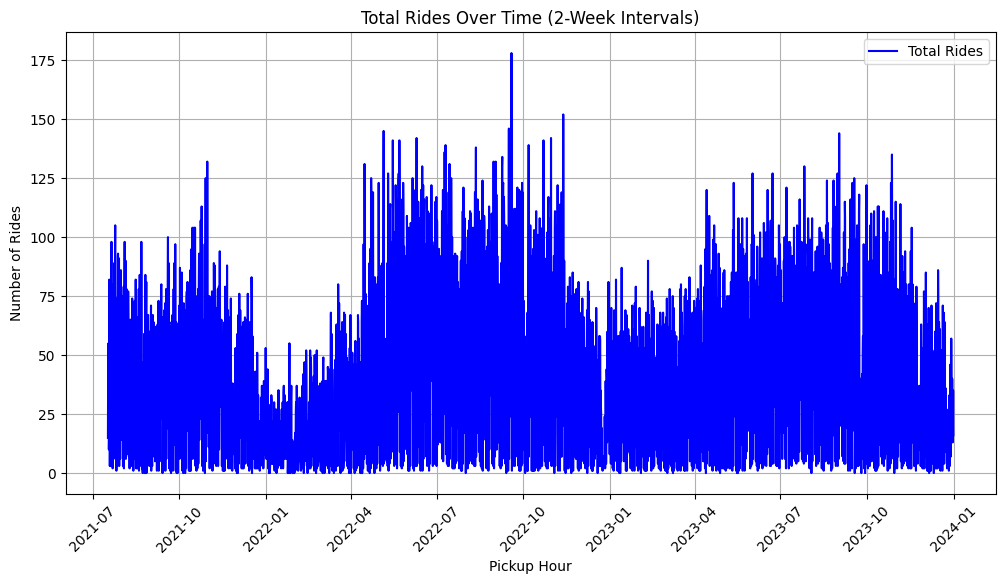

In [10]:
import matplotlib.pyplot as plt

# Convert 'pickup_hour' to datetime for proper plotting
df_2['pickup_hour'] = pd.to_datetime(df_2['pickup_hour'])

# Group data by 'pickup_hour' and sum rides for each hour
agg_data = df_2.groupby("pickup_hour")["rides"].sum()

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(agg_data.index, agg_data.values, label="Total Rides", color="blue")

# Add labels and title
plt.xlabel("Pickup Hour")
plt.ylabel("Number of Rides")
plt.title("Total Rides Over Time (2-Week Intervals)")
plt.legend()
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [11]:
agg_data

pickup_hour
2021-07-17 00:00:00    15
2021-07-17 06:00:00    45
2021-07-17 12:00:00    55
2021-07-17 18:00:00    47
2021-07-18 00:00:00    10
                       ..
2023-12-30 18:00:00    28
2023-12-31 00:00:00    13
2023-12-31 06:00:00    16
2023-12-31 12:00:00    35
2023-12-31 18:00:00    16
Name: rides, Length: 3592, dtype: int64

In [12]:
def transform_ts_data_info_features_and_target(
    df, feature_col="rides", window_size=12, step_size=1
):
    # Get all unique location IDs
    location_ids = df["station_id"].unique()
    # List to store transformed data for each location
    transformed_data = []

    # Loop through each location ID and transform the data
    for location_id in location_ids:
        try:
            # Filter the data for the given location ID
            location_data = df[df["station_id"] == location_id].reset_index(
                drop=True
            )

            # Extract the feature column and pickup_hour as NumPy arrays
            values = location_data[feature_col].values
            times = location_data["pickup_hour"].values

            # Ensure there are enough rows to create at least one window
            if len(values) <= window_size:
                raise ValueError("Not enough data to create even one window.")

            # Create the tabular data using a sliding window approach
            rows = []
            for i in range(0, len(values) - window_size, step_size):
                # The first `window_size` values are features, and the next value is the target
                features = values[i : i + window_size]
                target = values[i + window_size]
                # Get the corresponding target timestamp
                target_time = times[i + window_size]
                # Combine features, target, location_id, and timestamp
                row = np.append(features, [target, location_id, target_time])
                rows.append(row)

            # Convert the list of rows into a DataFrame
            feature_columns = [
                f"{feature_col}_t-{window_size - i}" for i in range(window_size)
            ]
            all_columns = feature_columns + [
                "target",
                "station_id",
                "pickup_hour",
            ]
            transformed_df = pd.DataFrame(rows, columns=all_columns)

            # Append the transformed data to the list
            transformed_data.append(transformed_df)

        except ValueError as e:
            print(f"Skipping location_id {location_id}: {str(e)}")

    # Combine all transformed data into a single DataFrame
    if not transformed_data:
        raise ValueError(
            "No data could be transformed. Check if input DataFrame is empty or window size is too large."
        )

    final_df = pd.concat(transformed_data, ignore_index=True)

    # Extract features (including pickup_hour), targets, and keep the complete DataFrame
    features = final_df[feature_columns + ["pickup_hour", "station_id"]]
    targets = final_df["target"]

    return features, targets

In [13]:
# hours = 3
# days = 7
# window_size = hours * days
features, targets = transform_ts_data_info_features_and_target(df_2, window_size=672, step_size=1)

In [14]:
transformed_df = pd.concat([features, targets], axis=1)
transformed_df.to_csv(TRANSFORMED_DATA_DIR / 'transformed_data_6h.csv', index=False)

In [15]:
transformed_df

,rides_t-672,rides_t-671,rides_t-670,rides_t-669,rides_t-668,rides_t-667,rides_t-666,rides_t-665,rides_t-664,rides_t-663,...,rides_t-7,rides_t-6,rides_t-5,rides_t-4,rides_t-3,rides_t-2,rides_t-1,pickup_hour,station_id,target
0,15,38,43,43,10,12,73,40,2,15,...,2,21,16,6,6,22,15,2022-01-01 00:00:00,HB101,8
1,38,43,43,10,12,73,40,2,15,50,...,21,16,6,6,22,15,8,2022-01-01 06:00:00,HB101,4
2,43,43,10,12,73,40,2,15,50,40,...,16,6,6,22,15,8,4,2022-01-01 12:00:00,HB101,4
3,43,10,12,73,40,2,15,50,40,2,...,6,6,22,15,8,4,4,2022-01-01 18:00:00,HB101,3
4,10,12,73,40,2,15,50,40,2,34,...,6,22,15,8,4,4,3,2022-01-02 00:00:00,HB101,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,5,1,5,13,9,3,13,19,9,3,...,0,10,10,5,3,4,12,2023-12-30 18:00:00,HB305,4
8756,1,5,13,9,3,13,19,9,3,16,...,10,10,5,3,4,12,4,2023-12-31 00:00:00,HB305,2
8757,5,13,9,3,13,19,9,3,16,21,...,10,5,3,4,12,4,2,2023-12-31 06:00:00,HB305,6
8758,13,9,3,13,19,9,3,16,21,20,...,5,3,4,12,4,2,6,2023-12-31 12:00:00,HB305,6


In [39]:
# Print unique values in the station_id column of df_2
unique_station_ids = transformed_df["station_id"].unique()
print(unique_station_ids)

['HB101' 'HB105' 'HB305']
